In [1]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

from QA import set_mwd, get_radec_mw
from io_ import get_isdes

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
#
dr = 'dr9'
#survey = 'north' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
Nranfiles = 3
reg = 'desi'
dec_resol_ns = 32.375
if (dr == 'dr9sv'): Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20

pathdir = os.path.abspath(os.getcwd())+'/%s-%s_%s_zsuccess_scenarios' %(dr, reg, version)
ispathdir = os.path.isdir(pathdir)
if not ispathdir: os.mkdir(pathdir)

# for healpy
dr8pix     = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
dr9pix = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.44.0/pixweight/main/resolve/bright/pixweight-bright.fits'

if dr[:3] == 'dr8': pixfile = dr8pix
elif dr[:3] == 'dr9': pixfile = dr9pix
    
hdr          = fits.getheader(pixfile,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

In [3]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles

#CATALOGUE
cat = np.load(filesdir+dr+'/'+version+'/'+'NEW_bgstargets'+'.npy', mmap_mode='r+')
catinreg = (cat[reg]) & (cat['desi'])
cat = cat[catinreg]
print('CATALOGUE DONE...')

#RANDOMS
ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy', mmap_mode='r+')
ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy', mmap_mode='r+')
raninreg = (ran_ex[reg]) & (ran_ex['desi'])
ran = ran[raninreg]
ran_ex = ran_ex[raninreg]
print('RANDOMS DONE...')


CATALOGUE DONE...
RANDOMS DONE...


In [4]:
catinreg = np.ones(len(cat), dtype=bool)
raninreg = np.ones(len(ran), dtype=bool)

In [5]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(ran, randoms=True)

In [6]:
#Notes: This hpdict is used to get the area only using the randoms. 
#This use the randoms within the DESI footprint and without any masking (maskrand=None) as we want the area without wholes.
hpdict0 = get_dict(cat=None, pixmapfile=pixfile, hppix_ran=ran_ex['hppix'], hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                            desifootprint=True, namesels=None, target_outputs=False, log=True)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  213988655
bgsfracarea DONE...
regions DONE...
area_all = 14266 deg2
bgsarea_south = 9717 deg2
bgsarea_decals = 8603 deg2
bgsarea_des = 1113 deg2
bgsarea_north = 4549 deg2
bgsarea_south_n = 5324 deg2
bgsarea_south_s = 4393 deg2
bgsarea_svfields = 697 deg2
bgsarea_svfields_n = 201 deg2
bgsarea_svfields_s = 496 deg2
areas DONE...


In [7]:
#
bgsbut_fracs_but_lg = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF', 'LG'], bgsmask=bgsmask(), rlimit=21)

main = {}

schlegel_color = (cat['ZMAG'] - cat['W1MAG']) - 3/2.5 * (cat['GMAG'] - cat['RMAG']) + 1.2
rfibcol =(cat['RFIBERMAG'] < 20.75) | ((cat['RFIBERMAG'] < 21.5) & (schlegel_color > 0.))

# Main selection
main['nominal main'] = (bgsbut_fracs_but_lg) & (cat['RMAG'] < 19.5)
main['nominal lower'] = (bgsbut_fracs_but_lg) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.0)
main['nominal'] = (bgsbut_fracs_but_lg) & (cat['RMAG'] < 20.0)

# rfibcol selection
main['rfibcol main'] = ((bgsbut_fracs_but_lg) & (cat['RMAG'] < 19.5)) | ((bgsbut_fracs_but_lg) & (rfibcol) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.3))
main['rfibcol lower'] = ((bgsbut_fracs_but_lg) & (~rfibcol) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.0)) | ((bgsbut_fracs_but_lg) & (rfibcol) & (cat['RMAG'] > 20.3) & (cat['RMAG'] < 20.5))
main['rfibcol'] = (main['rfibcol main']) | (main['rfibcol lower'])

# rfibcol relaxed selection
main['rfibcol 2 main'] = ((bgsbut_fracs_but_lg) & (cat['RMAG'] < 19.5))
main['rfibcol 2 lower'] = ((bgsbut_fracs_but_lg) & (rfibcol) & (cat['RMAG'] > 19.5) & (cat['RMAG'] < 20.3))
main['rfibcol 2'] = (main['rfibcol 2 main']) | (main['rfibcol 2 lower'])


In [8]:
#dic with default BGS selection and in DESI footprint
hpdict = get_dict(cat=cat, pixmapfile=pixfile, hppix_ran=ran_ex['hppix'], hppix_cat=cat['hppix'], 
                      maskrand=((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])), maskcat=None, 
                          Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=cat['desi'], desifootprint=True, 
                              namesels=main, galb=cat['b'], log=True, survey='custom')

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  213988655
bgsfracarea DONE...
regions DONE...
area_all = 14082 deg2
bgsarea_south = 9589 deg2
bgsarea_decals = 8484 deg2
bgsarea_des = 1105 deg2
bgsarea_north = 4493 deg2
bgsarea_south_n = 5263 deg2
bgsarea_south_s = 4326 deg2
bgsarea_svfields = 690 deg2
bgsarea_svfields_n = 199 deg2
bgsarea_svfields_s = 491 deg2
areas DONE...
computing for  north / nominal main
computing for  north / nominal lower
computing for  north / nominal
computing for  north / rfibcol main
computing for  north / rfibcol lower
computing for  north / rfibcol
computing for  north / rfibcol 2 main
computing for  north / rfibcol 2 lower
computing for  north / rfibcol 2
target densities in north DONE...
computing for  south / nominal main
computing for  south / nominal lower
computing for  south / nominal
computing for  south / rfibcol main
computing for  south / rfibcol lower
computing for  south / rfibcol
computing for  south

In [9]:
if reg == 'desi':
    survey = 'all'
    bgsarea = 'area'
else:
    survey = reg
    bgsarea = 'bgsarea'

In [10]:
#
import pandas as pd

def densities(cat, main, hpdict, keys):
    
    densities = {'BGS':[], 'BASS/MzLS':[], 'DECaLS':[]}
    N = 1
    for key in keys:

        val = main[key]

        densities['BGS'].append(key)
        densities['BASS/MzLS'].append(np.round(np.sum((val) & (cat['north']))/hpdict['%s_%s' %('bgsarea', 'north')], N))
        densities['DECaLS'].append(np.round(np.sum((val) & (cat['south']))/hpdict['%s_%s' %('bgsarea', 'south')], N))
        #densities['DECaLS SGC'].append(np.round(np.sum((val) & (cat['south']) & (cat['b'] < 0))/hpdict['%s_%s' %('bgsarea', 'south_s')], N))
        #densities['DESI'].append(np.round(np.sum(val)/hpdict['%s_%s' %(bgsarea, survey)], 0))

    densities['BGS'].append('AREA')
    densities['BASS/MzLS'].append(np.round(hpdict['%s_%s' %('bgsarea', 'north')], N))
    densities['DECaLS'].append(np.round(hpdict['%s_%s' %('bgsarea', 'south')], N))
    #densities['DECaLS SGC'].append(np.round(hpdict['%s_%s' %('bgsarea', 'south_s')], N))

    tab = pd.DataFrame.from_dict(densities)
    
    return tab

``` python 

# Main selection
nominal main: (bgs) & (r<19.5)
nominal lower: (bgs) & (r>19.5) & (r<20)
    
# rfibcol selection
rfibcol main = ((bgs) & (r < 19.5)) | ((bgs) & (rfibcol) & (r > 19.5) & (r < 20.3))
rfibcol lower = ((bgs) & (~rfibcol) & (r > 19.5) & (r < 20.0)) | ((bgs) & (rfibcol) & (r > 20.3) & (r < 20.5))

# rfibcol relaxed selection
rfibcol 2 main = ((bgs) & (r < 19.5))
rfibcol 2 lower = ((bgs) & (rfibcol) & (r > 19.5) & (r < 20.3))

```

In [11]:
#
keys = ['nominal main', 'rfibcol main', 'rfibcol 2 main']
tab = densities(cat, main, hpdict, keys)
tab

,BGS,BASS/MzLS,DECaLS
0,nominal main,832.3,864.3
1,rfibcol main,1453.8,1491.1
2,rfibcol 2 main,832.3,864.3
3,AREA,4493.1,9588.6


In [12]:
keys = ['nominal lower', 'rfibcol lower', 'rfibcol 2 lower']
tab = densities(cat, main, hpdict, keys)
tab

,BGS,BASS/MzLS,DECaLS
0,nominal lower,574.1,594.0
1,rfibcol lower,320.9,337.7
2,rfibcol 2 lower,621.4,626.9
3,AREA,4493.1,9588.6


In [13]:
keys = ['nominal', 'rfibcol', 'rfibcol 2']
tab = densities(cat, main, hpdict, keys)
tab

,BGS,BASS/MzLS,DECaLS
0,nominal,1406.4,1458.3
1,rfibcol,1774.6,1828.9
2,rfibcol 2,1453.8,1491.1
3,AREA,4493.1,9588.6


In [14]:
def n_density(cat1, A):
    '''
    Get the cumulative number density
    '''
    
    eta = []
    mag = np.linspace(18, 20.5, 50)
    
    for i in range(len(mag)):
        
        N = len(cat1[cat1['RMAG'] < mag[i]])
        #eta.append([mag[i], etaR*(N/Nran)])
        eta.append([mag[i], N/A])
            
    eta = np.array(eta).transpose()
    #print('DONE...')
    
    return eta

In [15]:
#
etas = {}
#for regi in ['south_n', 'south_s', 'north', 'desi']:
for regi in ['south', 'north']:
    
    if regi != 'desi':
        A = hpdict['bgsarea_%s' %(regi)]
    else:
        A = hpdict['area_all']
        

    for key in ['nominal', 'rfibcol', 'rfibcol 2']:
        mask = (main[key]) & (cat[regi])
        
        etas['%s_%s' %(regi, key)] = n_density(cat1=cat[mask], A=A)
        print('%s %s --> A=%.2f --> Dens=%.2f' %(regi, key, A, np.sum(mask)/A))
        

KeyboardInterrupt: 

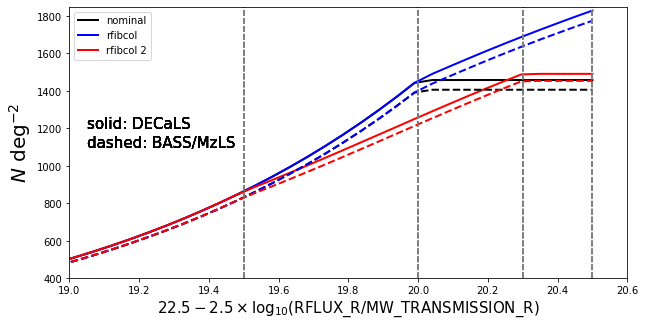

In [26]:
#
plt.figure(figsize=(10, 5))

styles = {'south_nominal':['k', '-'], 'south_rfibcol':['b', '-'], 'south_rfibcol 2':['r', '-'],
         'north_nominal':['k', '--'], 'north_rfibcol':['b', '--'], 'north_rfibcol 2':['r', '--']}

for num, (key, item) in enumerate(etas.items()):
    
    plt.plot(item[0], item[1], lw=2, ls=styles[key][1], color=styles[key][0], label='%s' %(key.split('_')[-1]) if num < 3 else None)
    plt.axvline(19.5, ls='--', color='gray')
    plt.axvline(20.0, ls='--', color='gray')
    plt.axvline(20.3, ls='--', color='gray')
    plt.axvline(20.5, ls='--', color='gray')
    plt.text(19.05, 1200, 'solid: DECaLS', size=15)
    plt.text(19.05, 1100, 'dashed: BASS/MzLS', size=15)
    #plt.axhline(800, c='gray', ls='--')
    #plt.axhline(1400, c='gray', ls='--')
    plt.xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('RFLUX_R', 'MW_TRANSMISSION_R'), fontsize=15)
    plt.ylabel(r'$N$ deg$^{-2}$', fontsize=20)
    plt.xlim(19,20.6)
    plt.ylim(400, 1850)
    plt.legend()
    plt.grid()

In [20]:
from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

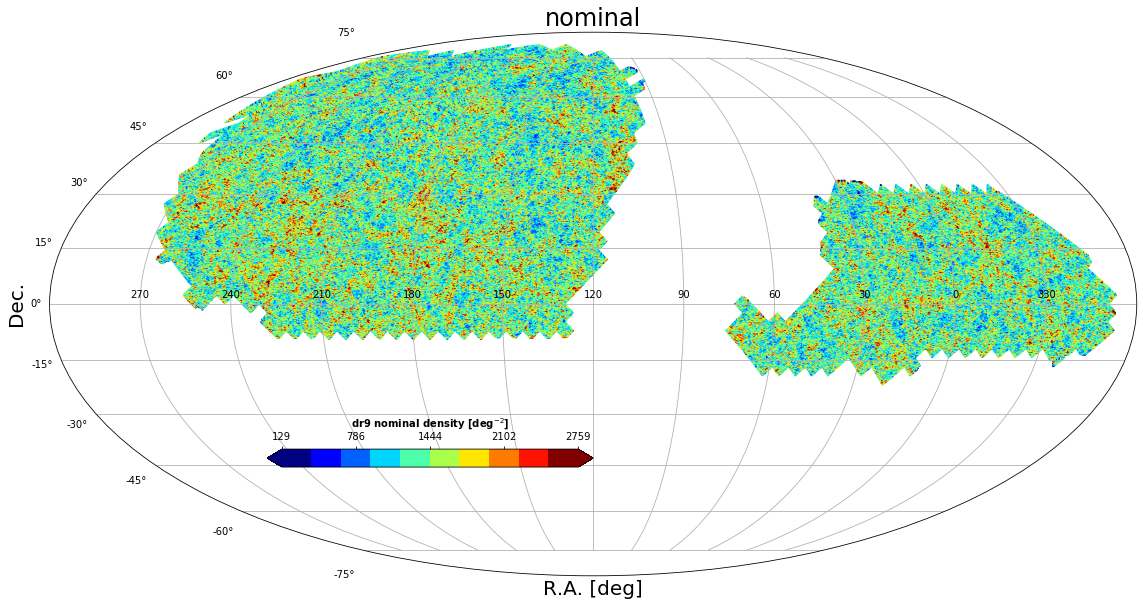

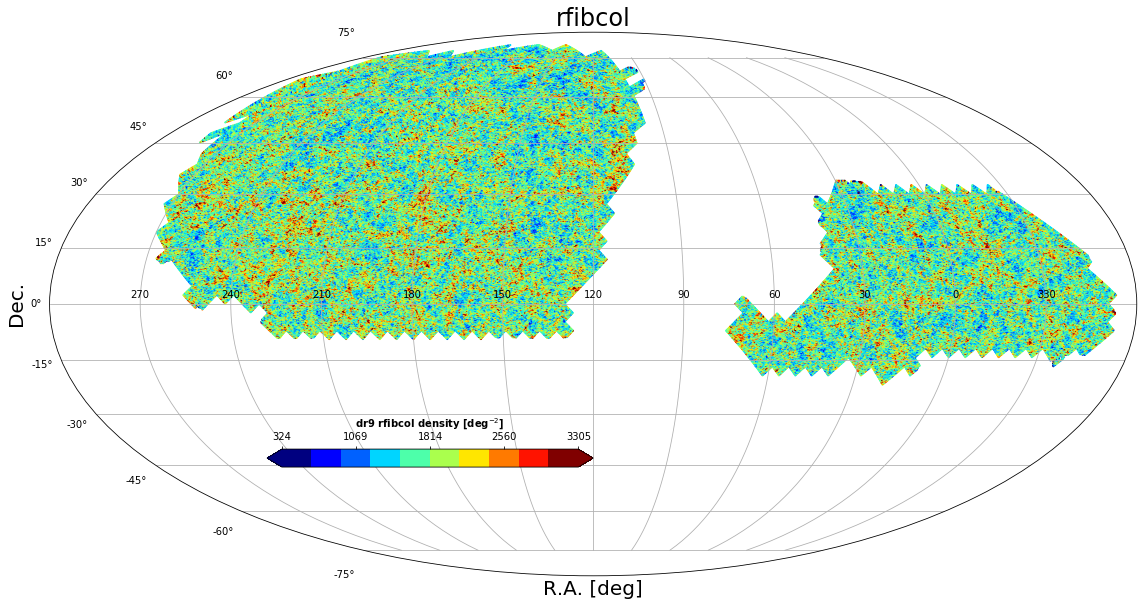

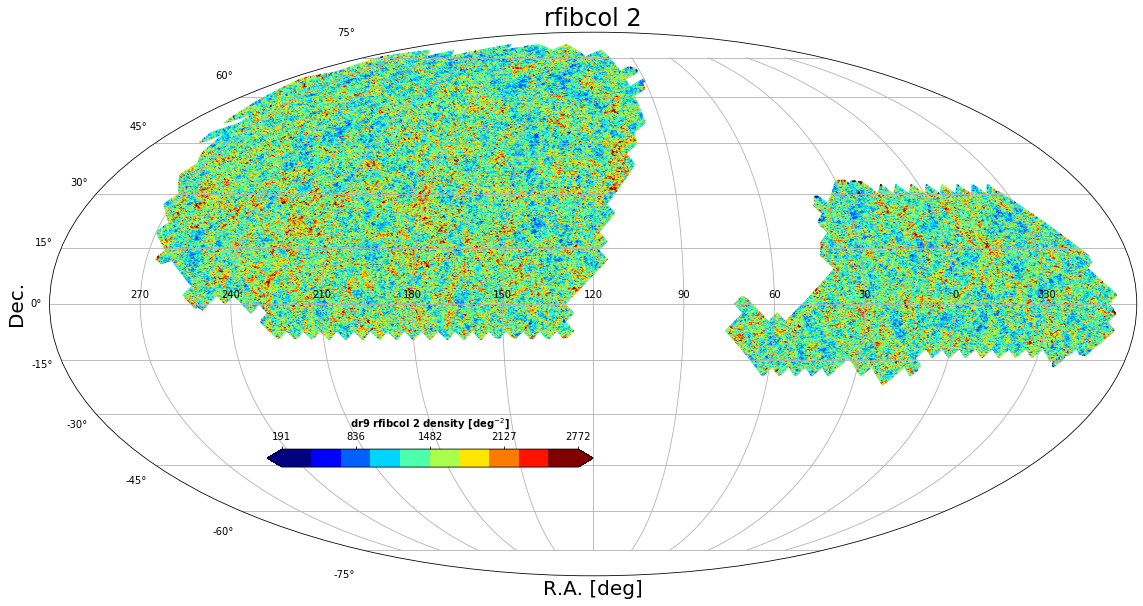

In [21]:
#
for i in ['nominal', 'rfibcol', 'rfibcol 2']:
    
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(1, 1)
    key = i

    org          = 120  # centre ra for mollweide plots
    projection   = 'mollweide'
    cm = mycmap(matplotlib.cm.jet, 10,0,1)
    cmr= mycmap(matplotlib.cm.jet_r,10,0,1)

    mollweide(hpdict=hpdict, namesel=key, reg=survey, projection=projection, n=0, org=org, cm=cm, fig=fig, gs=gs, cval=None, perc=(0.3,99.7), dr=dr, cname=None, title=key)

    file = '%s/skydens_%s_%s' %(pathdir, dr, key)
    fig.savefig(file+'.png', bbox_inches = 'tight', pad_inches = 0)

# Overlap with Dark time targets

In [43]:
%whos

Variable              Type         Data/Info
--------------------------------------------
A                     float64      9588.600866666664
N                     int          3
Nranfiles             int          3
SkyCoord              ABCMeta      <class 'astropy.coordinat<...>sky_coordinate.SkyCoord'>
Table                 type         <class 'astropy.table.table.Table'>
bgsarea               str          area
bgsbut                function     <function bgsbut at 0x2aaadf73f730>
bgsbut_fracs_but_lg   ndarray      37341872: 37341872 elems, type `bool`, 37341872 bytes (35.61198425292969 Mb)
bgsmask               function     <function bgsmask at 0x2aaadf76f6a8>
bits                  dict         n=3
cat                   Table                RA               <...>5\nLength = 37341872 rows
cat2                  Table                RA               <...>5\nLength = 37341872 rows
catinreg              ndarray      37341872: 37341872 elems, type `bool`, 37341872 bytes (35.611984252929

In [11]:
del ran_ex, rancuts, ran

In [12]:
cat2 = Table()
for i in ['RA', 'DEC']:
    cat2[i] = cat[i]

In [14]:
del cat

In [16]:
cat = cat2

In [22]:
#
from io_ import match_coord
def match_external(cat=None, ext=None):
    
    #if maskcat is None: maskcat = np.ones_like(cat, dtype=bool)
    # matching LS with gama stars and galaxies
    idx20, idx10, d2d0, d_ra0, d_dec0 = match_coord(cat['RA'], cat['DEC'], 
                                                                ext['RA'], ext['DEC'], search_radius=0.5)

    # LS DR8 matched with gama
    cat_ext = np.zeros_like(cat['RA'], dtype='?') #LS that match with gama

    cat_ext[idx20.tolist()] = True
    
    return cat_ext

## Main Selection

In [34]:
dark_main = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/desitarget/dr9_0.49.0_targets_main_resolve_dark.npy')

In [35]:
#
extra = Table()

extra['RA'] = dark_main['RA']
extra['DEC'] = dark_main['DEC']
extra['DESI_TARGET'] = dark_main['DESI_TARGET']

#angle to healpy pixels array
extra['hppix'] = hp.ang2pix(nside,(90.-dark_main['DEC'])*np.pi/180.,dark_main['RA']*np.pi/180.,nest=True)

#
extra['desi'] = get_reg(reg='desi', hppix=extra['hppix'])
extra['north'] = get_reg(reg='north', hppix=extra['hppix'])
extra['south'] = get_reg(reg='south', hppix=extra['hppix'])


In [36]:
dark_main = extra[extra['desi']]

In [37]:
del extra

In [38]:
#DESI target classes
bits = {'ELG':2**(1), 'QSO':2**(2), 'LRG':2**(0)}
targ_list = {}
for key, val in bits.items():
    targ_list[key] = (dark_main["DESI_TARGET"] & val) != 0
    for i in ['south', 'north']:
        print(key+' '+i, np.sum((targ_list[key]) & (dark_main[i])))


ELG south 23350843
ELG north 11501467
QSO south 2751458
QSO north 1335593
LRG south 5841262
LRG north 2715828


In [47]:
#
mask = cat['south']
mask2 = targ_list['LRG']
lrg = match_external(cat={'RA':cat['RA'], 'DEC':cat['DEC']}, ext={'RA':dark_main['RA'][mask2], 'DEC':dark_main['DEC'][mask2]})

Doubly matched objects = 20
Final matched objects = 2450848


In [49]:
#
matches = {}

for key in targ_list.keys():
    
    mask = targ_list[key]
    %time matches[key] = match_external(cat={'RA':cat['RA'], 'DEC':cat['DEC']}, ext={'RA':dark_main['RA'][mask], 'DEC':dark_main['DEC'][mask]})
    print(key, 'DONE...')
    

Doubly matched objects = 12
Final matched objects = 123070
CPU times: user 1min 26s, sys: 19.1 s, total: 1min 45s
Wall time: 1min 36s
ELG DONE...
Doubly matched objects = 19
Final matched objects = 775783
CPU times: user 31.8 s, sys: 7.09 s, total: 38.8 s
Wall time: 34.9 s
QSO DONE...
Doubly matched objects = 20
Final matched objects = 2450848
CPU times: user 53 s, sys: 9.47 s, total: 1min 2s
Wall time: 57.2 s
LRG DONE...


In [53]:
#
overlap = {}
for key, val in main.items():
    for key2, val2 in matches.items():
        
        overlap['%s & %s' %(key, key2)] = (val) & (val2)


In [56]:
#
keys = ['nominal & ELG', 'rfibcol & ELG', 'rfibcol 2 & ELG',
        'nominal & LRG', 'rfibcol & LRG', 'rfibcol 2 & LRG',
        'nominal & QSO', 'rfibcol & QSO', 'rfibcol 2 & QSO']
tab_den = densities(cat, overlap, hpdict, keys)

In [57]:
tab_den

,BGS,BASS/MzLS,DECaLS
0,nominal & ELG,0.5,0.6
1,rfibcol & ELG,1.2,1.8
2,rfibcol 2 & ELG,0.7,1.0
3,nominal & LRG,107.7,117.1
4,rfibcol & LRG,120.7,128.8
5,rfibcol 2 & LRG,88.2,93.8
6,nominal & QSO,0.5,0.5
7,rfibcol & QSO,1.1,1.5
8,rfibcol 2 & QSO,0.8,0.8
9,AREA,4493.1,9588.6


## SV1 Selection

In [17]:
dark_main = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/desitarget/dr9_0.49.0_targets_sv1_resolve_dark.npy')

In [18]:
#
extra = Table()

extra['RA'] = dark_main['RA']
extra['DEC'] = dark_main['DEC']
extra['SV1_DESI_TARGET'] = dark_main['SV1_DESI_TARGET']

#angle to healpy pixels array
hppix = hp.ang2pix(nside,(90.-dark_main['DEC'])*np.pi/180.,dark_main['RA']*np.pi/180.,nest=True)
#
desi = get_reg(reg='desi', hppix=hppix)

dark_main = extra[desi]

In [19]:
del hppix, desi, extra

In [20]:
#DESI target classes
bits = {'ELG':2**(1), 'QSO':2**(2), 'LRG':2**(0)}
targ_list = {}
for key, val in bits.items():
    targ_list[key] = (dark_main["SV1_DESI_TARGET"] & val) != 0
    print(key, np.sum((targ_list[key])))


ELG 101086626
QSO 12217131
LRG 30660612


In [ ]:
#
matches = {}

for key in targ_list.keys():
    
#     print(key, np.sum(targ_list[key]))
    
    mask = targ_list[key]
    %time matches[key] = match_external(cat={'RA':cat['RA'], 'DEC':cat['DEC']}, ext={'RA':dark_main['RA'][mask], 'DEC':dark_main['DEC'][mask]})
    print(key, 'DONE...')
    

In [53]:
#
overlap = {}
for key, val in main.items():
    for key2, val2 in matches.items():
        
        overlap['%s & %s' %(key, key2)] = (val) & (val2)


In [56]:
#
keys = ['nominal & ELG', 'rfibcol & ELG', 'rfibcol 2 & ELG',
        'nominal & LRG', 'rfibcol & LRG', 'rfibcol 2 & LRG',
        'nominal & QSO', 'rfibcol & QSO', 'rfibcol 2 & QSO']
tab_den = densities(cat, overlap, hpdict, keys)

In [57]:
tab_den

,BGS,BASS/MzLS,DECaLS
0,nominal & ELG,0.5,0.6
1,rfibcol & ELG,1.2,1.8
2,rfibcol 2 & ELG,0.7,1.0
3,nominal & LRG,107.7,117.1
4,rfibcol & LRG,120.7,128.8
5,rfibcol 2 & LRG,88.2,93.8
6,nominal & QSO,0.5,0.5
7,rfibcol & QSO,1.1,1.5
8,rfibcol 2 & QSO,0.8,0.8
9,AREA,4493.1,9588.6
